# load one of 4 folders

adjust base path based on location

In [29]:
Base_path = "C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/"
Json_paths= []
for scan in range(0,647):
    Json_path = Base_path + "LIDC-IDRI-0"+ str(scan).zfill(3) + "/*/*/" + "segmentation_00"+str(scan).zfill(3)+".json"
    Json_paths.append(Json_path)
    #print(Json_path)
print(Json_paths)

['C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0000/*/*/segmentation_00000.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/*/*/segmentation_00001.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0002/*/*/segmentation_00002.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0003/*/*/segmentation_00003.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0004/*/*/segmentation_00004.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0005/*/*/segmentation_00005.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0006/*/*/segmentation_00006.json', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0007/*/*/segmentat

# Choose ct scan

In [2]:
import json
import glob
import re
import numpy as np
from skimage.draw import polygon
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, disk,binary_opening, remove_small_objects
from scipy.ndimage import binary_fill_holes,label,binary_dilation,binary_erosion
import pydicom
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio.v2 as imageio
from pathlib import Path
import os
from pydicom.dataset import Dataset, FileDataset

In [31]:
# in this case number between 0 and 646
file = glob.glob(Json_paths[1])
file = file[0].replace("\\", "/")
slice_paths = []
slice_coords = []

with open(file) as f:
    d = json.load(f)
    dicom_file_base = re.sub(r"segmentation.*\.json", "1-", file)
    for slice in range(0,len(d["annotation"])):
        slice_path = dicom_file_base +str(next(iter(d["annotation"][slice]))).zfill(4)+".dcm"
        slice_paths.append(slice_path)
        slice_coord = d["annotation"][slice][next(iter(d["annotation"][slice]))]['segmentation'][0]
        slice_coords.append(slice_coord)
print(slice_paths)
print(np.array(slice_coords[0])*512)

['C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-02684/1115371.000000-NA-34253/1-0070.dcm', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-02684/1115371.000000-NA-34253/1-0071.dcm', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-02684/1115371.000000-NA-34253/1-0072.dcm', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-02684/1115371.000000-NA-34253/1-0073.dcm', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-02684/1115371.000000-NA-34253/1-0074.dcm', 'C:/Users/Aidan/Tue/5ARIP10/Demcon_Data/20241221_074106/20241221_074106/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-02684/1115371.000000-NA-34253/1-0075.dcm']
[212.77915955 312.88751221 215.06471252 312.64474487 215.

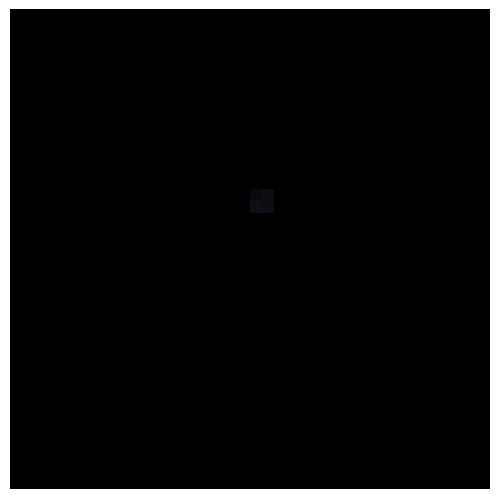

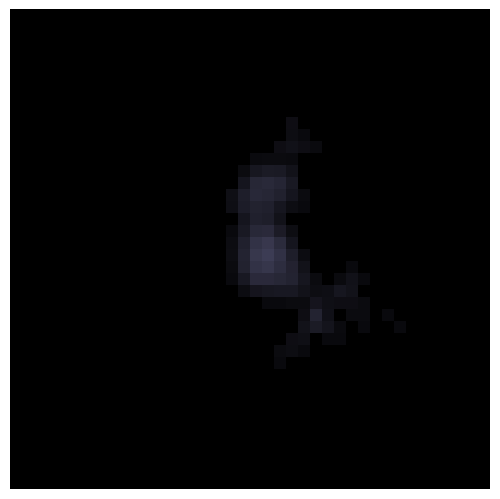

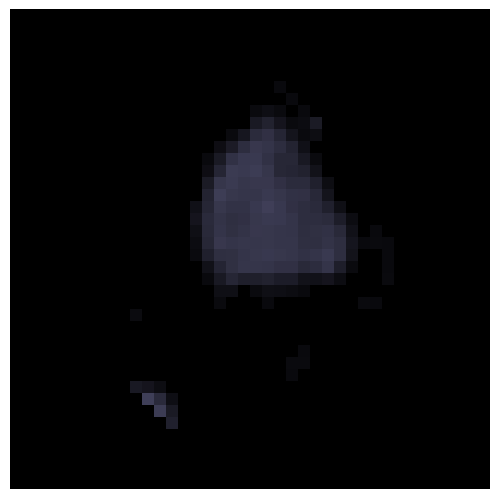

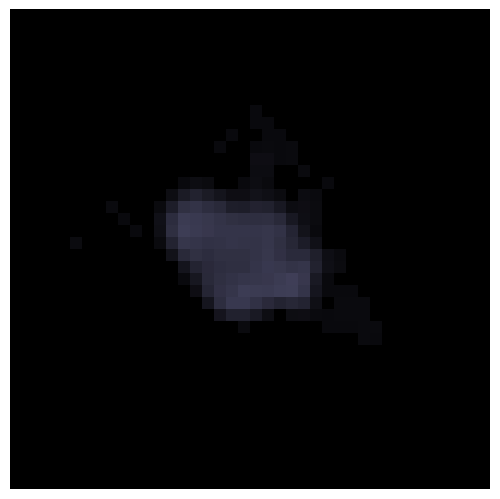

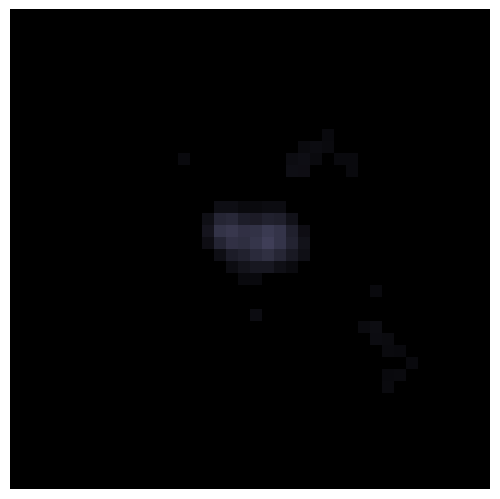

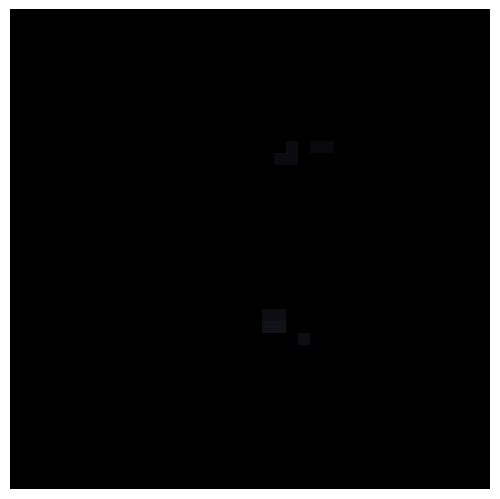

In [ ]:
def save_as_dicom(original_dicom, image_array, output_path):
    # Create a new DICOM dataset based on the original
    new_dicom = original_dicom.copy()

    # Update pixel data with the new padded image
    new_dicom.Rows, new_dicom.Columns = image_array.shape
    new_dicom.PixelData = image_array.astype(np.uint16).tobytes()  # Convert to bytes

    # Save as DICOM
    new_dicom.save_as(output_path)
    print(f"Saved: {output_path}")


def pad_to_size(image,size):
    height, width = image.shape
    
    # Calculate padding amounts
    pad_top = (size - height) // 2
    pad_bottom = size - height - pad_top
    pad_left = (size - width) // 2
    pad_right = size - width - pad_left

    # Apply padding (black pixels = 0)
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

    return padded_image


for slice_index in range(0, len(slice_coords)):
    slice = slice_coords[slice_index]
    slice_path = slice_paths[slice_index]

    dicom_data = pydicom.dcmread(slice_path)
    image_org = dicom_data.pixel_array

    image = dicom_data.pixel_array.astype(np.float32)

    # Normalize image
    #image = (image - np.min(image)) / (np.max(image) - np.min(image))

    non_black_mask = image > 0  # Ignore pure black regions outside scan
    scan_region = binary_fill_holes(non_black_mask)  # Fill holes in the scan area

    thresh = threshold_otsu(image[scan_region])
    lung_mask = (image < thresh) & scan_region

    #clean up
    #lung_mask = binary_opening(lung_mask, disk(2))  # Remove noise
    lung_mask = binary_dilation(lung_mask, iterations=3) # add pixels back
    lung_mask = binary_fill_holes(lung_mask)  # Fill small holes

    # Label connected components and keep the two **largest regions** (lungs)
    labeled_mask, num_features = label(lung_mask)
    unique, counts = np.unique(labeled_mask, return_counts=True)
    sorted_labels = sorted(zip(unique[1:], counts[1:]), key=lambda x: -x[1])[:2]  # Top 2 largest
    lung_mask = np.isin(labeled_mask, [s[0] for s in sorted_labels])  # Keep only lungs

    lung_mask = binary_erosion(lung_mask, disk(4)) # remove lung wall as much as possible

    # Apply the final mask
    lungs_only = np.zeros_like(image)
    lungs_only[lung_mask] = image[lung_mask]

    height, width = image.shape

    x_coords = slice[::2]
    y_coords = slice[1::2]
    
    x_coords_new = (np.array(x_coords) * width).astype(int)
    y_coords_new = (np.array(y_coords) * height).astype(int)
    

    mask = np.zeros_like(image, dtype=bool)

    # Get nodule area to fill
    rr, cc = polygon(y_coords_new, x_coords_new, mask.shape)
    mask[rr, cc] = True

    # Fill any holes inside the nodule
    mask = binary_fill_holes(mask)

    # Expand mask by 4 pixels to account for offset
    mask = binary_dilation(mask, iterations=3)
    

    # Create the masked image
    masked_image = np.zeros_like(lungs_only)
    masked_image[mask] = lungs_only[mask]

    min_x = min(x_coords_new)
    max_x = max(x_coords_new)
    min_y = min(y_coords_new)
    max_y = max(y_coords_new)

    padding = 5  # padding for bounding box
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    cropped_image = masked_image[min_y:max_y, min_x:max_x]

    cropped_image = pad_to_size(cropped_image,40)
    cropped_image[(cropped_image < 130)] = 0 # remove pixels surounding nodule as much as possible

    figsize = (40 / 100, 40 / 100)

    # Display the cropped region, either in 60x60 pixels, or higher quality for viewing
    #fig, ax = plt.subplots(figsize=figsize,dpi = 100)
    fig, ax = plt.subplots()

    fig.patch.set_visible(False)  
    ax.set_frame_on(False)

    ax.imshow(cropped_image, cmap=plt.cm.bone, vmin=image_org.min(), vmax=image_org.max())
    #plt.title("Extracted Region from DICOM")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_position([0, 0, 1, 1])


plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()